# Measurement of projected 2point correlation function $w(\theta)$ of galaxy clusters
## Testing and validation of the code "twopoint_cluster.py"

In [1]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import txpipe.data_types
import sacc
import yaml
from pprint import pprint
import time
import ceci

%matplotlib inline

In [2]:
# pipeline file needed to run ceci
print('PIPELINE FILE:\n ')
pipeline_file     = 'examples/twopoint_cluster/config/pipeline_clusters.yml'
pipeline_clusters = yaml.safe_load(open(pipeline_file)) 
pprint(pipeline_clusters)


# the pipeline file calls a configuration file with input settings for the clustering class
print('\n\nCONFIGURATION FILE:\n ')
config_file     = "examples/twopoint_cluster/config/config_clusters.yml" 
config_clusters = yaml.safe_load(open(config_file)) 
pprint(config_clusters)

PIPELINE FILE:
 
{'config': 'examples/twopoint_cluster/config/config_clusters.yml',
 'inputs': {'cluster_data_catalog': 'examples/twopoint_cluster/catalogs/data_tomographic.hdf5',
            'cluster_random_catalog': 'examples/twopoint_cluster/catalogs/random_tomographic.hdf5',
            'fiducial_cosmology': 'examples/twopoint_cluster/config/fiducial_cosmology.yml'},
 'launcher': {'interval': 1.0, 'name': 'mini'},
 'log_dir': 'examples/twopoint_cluster/',
 'modules': 'txpipe rail.creation.degraders.grid_selection '
            'rail.creation.engines.flowEngine rail.estimation.algos.nz_dir '
            'rail.estimation.algos.bpz_lite',
 'output_dir': 'examples/twopoint_cluster/outputs/test/',
 'pipeline_log': 'examples/twopoint_cluster/log.txt',
 'python_paths': ['submodules/WLMassMap/python/desc/'],
 'resume': True,
 'site': {'max_threads': 2, 'name': 'local'},
 'stages': [{'name': 'TXTwoPointCluster', 'outputs': 'test_out_name'}]}


CONFIGURATION FILE:
 
{'TXTwoPointCluster': {'b

## Modify settings trough the pipeline.yml and config.yml files

In [3]:
# to modify the CONFIG file directly from here (if needed), change things here and rewrite the file
config_clusters = yaml.safe_load(open(config_file)) 

# check redshift and richness bins in the tomographic catalogs
# and modify the CONFIG file accordingly
with h5py.File('examples/twopoint_cluster/catalogs/data_tomographic.hdf5', 'r+') as f:
    zbins = f['cluster_bin'].attrs['redshift_bins'].tolist()
    lbins = f['cluster_bin'].attrs['richness_bins'].tolist()
print('Redshift bins: ', zbins)
print('Richness bins: ', lbins)

config_clusters['TXTwoPointCluster']['richness_bin_edges'] = lbins
config_clusters['TXTwoPointCluster']['redshift_bin_edges'] = zbins

# write the updated file
with open(config_file, 'w') as file:
    yaml.safe_dump(config_clusters, file)

Redshift bins:  [0.4, 0.8, 1.2]
Richness bins:  [20, 30, 200]


In [4]:
# to modify the PIPELINE file directly from here (if needed), change things here and rewrite the file
pipeline_clusters = yaml.safe_load(open(pipeline_file)) 

# example: change input files
pipeline_clusters['inputs']['cluster_data_catalog']   = 'examples/twopoint_cluster/catalogs/data_tomographic.hdf5'    # path to data catalog (hdf5)
pipeline_clusters['inputs']['cluster_random_catalog'] = 'examples/twopoint_cluster/catalogs/random_tomographic.hdf5'  # path to random catalog (hdf5)


#### not clear how to modify the output file name from here
#### up to now, it can only be changed directly in the twopoint_cluster.py file
#### as a temporary option, one can change the output directory as
pipeline_clusters['output_dir'] = 'examples/twopoint_cluster/outputs/test/'

# write the updated file
with open(pipeline_file, 'w') as file:
    yaml.safe_dump(pipeline_clusters, file)

In [5]:
# if the file already exists, remove it 
# (otherwise the code will not re-compute it)
if os.path.isfile(pipeline_clusters['output_dir']+'cluster_twopoint_real.sacc'):
    os.remove(pipeline_clusters['output_dir']+'cluster_twopoint_real.sacc')


## Run the pipeline and measure $w(\theta)$

In [18]:
# set pipeline with updated config and pipeline files
pipeline = ceci.Pipeline.read(pipeline_file)

# run the pipeline (just cluster clustering part here)
st = time.time()
pipeline.run()
print('Time: %2.3f sec' %(time.time()-st))


Executing TXTwoPointCluster
Command is:
OMP_NUM_THREADS=1 PYTHONPATH=submodules/WLMassMap/python/desc/:$PYTHONPATH  python3 -m txpipe TXTwoPointCluster   --cluster_data_catalog=examples/twopoint_cluster/catalogs/data_tomographic.hdf5   --cluster_random_catalog=examples/twopoint_cluster/catalogs/random_tomographic.hdf5   --config=examples/twopoint_cluster/config/config_clusters.yml   --cluster_twopoint_real=examples/twopoint_cluster/outputs/test//cluster_twopoint_real.sacc 
Output writing to examples/twopoint_cluster//TXTwoPointCluster.out

Job TXTwoPointCluster has completed successfully!
Time: 24.263 sec


## Measure $w(\theta)$ with another code (based on CorrFunc package) for validation

In [19]:
## To run this, you need to install the CorrFunc package !!
from Corrfunc.mocks import DDtheta_mocks

nthreads = 1

config_clusters = yaml.safe_load(open("examples/twopoint_cluster/config/config_clusters.yml" )) 

# radial separation
theta_min = config_clusters['TXTwoPointCluster']['min_sep']
theta_max = config_clusters['TXTwoPointCluster']['max_sep']
nbins_t   = config_clusters['TXTwoPointCluster']['nbins']


# log or linear binning
if config_clusters['TXTwoPointCluster']['binning_scale'] == 'Log':
    theta  = np.geomspace(theta_min, theta_max, nbins_t+1) 
else:
    theta  = np.linspace(theta_min, theta_max, nbins_t+1) 
    
# corrfunc wants angular separation in degrees
if config_clusters['TXTwoPointCluster']['units'] == 'arcmin':
    theta_degrees = theta / 60        # Convert to degrees
elif config_clusters['TXTwoPointCluster']['units'] == 'degrees':
    theta_degrees = theta

# set richness bins
lbins   = np.array(config_clusters['TXTwoPointCluster']['richness_bin_edges'])
nbins_l = len(lbins)-1

# set richness bins
zbins   = np.array(config_clusters['TXTwoPointCluster']['redshift_bin_edges'])
nbins_z = len(zbins)-1

# read random and data file
rand = h5py.File(pipeline_clusters['inputs']['cluster_random_catalog'], 'r+') 
data = h5py.File(pipeline_clusters['inputs']['cluster_data_catalog'],   'r+') 

ra    = {}
dec   = {}
ra_r  = {}
dec_r = {}
for iz in range(nbins_z):
    
    for il in range(nbins_l):
        
        ra_r['bin_zbin_%s_richbin_%s' %(iz,il)]  = rand['cluster_bin']['bin_zbin_%s_richbin_%s'%(iz,il)]['ra'][:]
        dec_r['bin_zbin_%s_richbin_%s' %(iz,il)]  = rand['cluster_bin']['bin_zbin_%s_richbin_%s'%(iz,il)]['dec'][:] 
        
        ra['bin_zbin_%s_richbin_%s' %(iz,il)]   = data['cluster_bin']['bin_zbin_%s_richbin_%s'%(iz,il)]['ra'][:] 
        dec['bin_zbin_%s_richbin_%s' %(iz,il)]  = data['cluster_bin']['bin_zbin_%s_richbin_%s'%(iz,il)]['dec'][:] 

rand.close()
data.close()


st = time.time()

# measure auto- and cross-correlation functions between richness bins
w_corrfunc = {}
for iz in range(nbins_z):
    
    for il in range(nbins_l):
        
        for jl in range(il, nbins_l):
    
            # Compute DD(theta) - pair counts between the data points
            dd_counts = DDtheta_mocks(autocorr=0, nthreads=nthreads, binfile=theta_degrees, 
                                      RA1=ra['bin_zbin_%s_richbin_%s' %(iz,il)], DEC1=dec['bin_zbin_%s_richbin_%s' %(iz,il)],
                                      RA2=ra['bin_zbin_%s_richbin_%s' %(iz,jl)], DEC2=dec['bin_zbin_%s_richbin_%s' %(iz,jl)])
            DiDj   = np.array([item['npairs'] for item in dd_counts], dtype=float)  # Extract pair counts
    
            
            # Compute RR(theta) - pair counts between the random points
            rr_counts = DDtheta_mocks(autocorr=0, nthreads=nthreads, binfile=theta_degrees,
                                      RA1=ra_r['bin_zbin_%s_richbin_%s' %(iz,il)], DEC1=dec_r['bin_zbin_%s_richbin_%s' %(iz,il)],
                                      RA2=ra_r['bin_zbin_%s_richbin_%s' %(iz,jl)], DEC2=dec_r['bin_zbin_%s_richbin_%s' %(iz,jl)])
            RiRj = np.array([item['npairs'] for item in rr_counts], dtype=float)
            
                    
            # Compute DR(theta) - pair counts between data_i and random_j points
            dr_counts = DDtheta_mocks(autocorr=0, nthreads=nthreads, binfile=theta_degrees, 
                                      RA1=ra['bin_zbin_%s_richbin_%s' %(iz,il)], DEC1=dec['bin_zbin_%s_richbin_%s' %(iz,il)],
                                      RA2=ra_r['bin_zbin_%s_richbin_%s' %(iz,jl)], DEC2=dec_r['bin_zbin_%s_richbin_%s' %(iz,jl)])
            DiRj = np.array([item['npairs'] for item in dr_counts], dtype=float)

            # Compute RD(theta) - pair counts between data_j and random_i points
            dr_counts = DDtheta_mocks(autocorr=0, nthreads=nthreads, binfile=theta_degrees, 
                                      RA1=ra['bin_zbin_%s_richbin_%s' %(iz,jl)], DEC1=dec['bin_zbin_%s_richbin_%s' %(iz,jl)], 
                                      RA2=ra_r['bin_zbin_%s_richbin_%s' %(iz,il)], DEC2=dec_r['bin_zbin_%s_richbin_%s' %(iz,il)])
            RiDj = np.array([item['npairs'] for item in dr_counts], dtype=float)
    
            # normalize the pair counts and compute correlations
            ND_i = len(ra['bin_zbin_%s_richbin_%s' %(iz,il)])
            ND_j = len(ra['bin_zbin_%s_richbin_%s' %(iz,jl)])
            NR_i = len(ra_r['bin_zbin_%s_richbin_%s' %(iz,il)])
            NR_j = len(ra_r['bin_zbin_%s_richbin_%s' %(iz,jl)])
    
            DiDj_norm = DiDj/(ND_i*ND_j)
            DiRj_norm = DiRj/(ND_i*NR_j)
            RiDj_norm = RiDj/(NR_i*ND_j)
            RiRj_norm = RiRj/(NR_i*NR_j)
    
            w_corrfunc['zbin_%s_rich_bin_%s - rich_bin_%s' %(iz,il,jl)]  = (DiDj_norm - DiRj_norm - RiDj_norm + RiRj_norm)/RiRj_norm

print('Time: %2.3f sec' %(time.time()-st))

Time: 66.922 sec


## Validation against external measurements (same data, CorrFunc package)

Text(0.5, 1.0, 'Redshift slice z = 0.4 - 0.8')

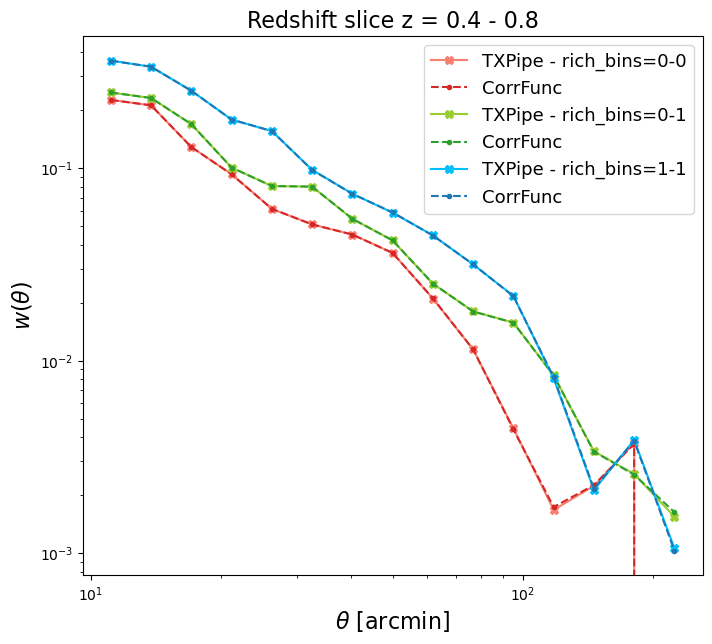

In [20]:
iz  = 0

cvec0 = ['salmon','yellowgreen','deepskyblue']
cvec1 = ['C3','C2','C0']

# read w(theta) from sacc file (saved before)   
s  = sacc.Sacc.load_fits("examples/twopoint_cluster/outputs/test/cluster_twopoint_real.sacc")

# mean separation bins
theta_m   = 10**(np.log10(theta[1:]*theta[:-1])/2)

plt.figure(figsize=(8,7))
for il in range(nbins_l):
    for jl in range(il,nbins_l):
        w_txpipe = s.get_mean('cluster_density_xi', ('zbin_%s_richbin_%s' %(iz,il), 'zbin_%s_richbin_%s' %(iz,jl)))
        
        plt.plot(theta_m, w_txpipe,  'X-', c=cvec0[il+jl], label='TXPipe - rich_bins=%s-%s' %(il,jl))
        plt.plot(theta_m, w_corrfunc['zbin_%s_rich_bin_%s - rich_bin_%s' %(iz,il,jl)],  '.--', c=cvec1[il+jl],  label='CorrFunc')
    
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=13,loc=0)
plt.xlabel(r'$\theta$ [arcmin]', fontsize=16)
plt.ylabel(r'$w(\theta)$', fontsize=16)
plt.title(r'Redshift slice z = %1.1f - %1.1f' %(zbins[iz],zbins[iz+1]), fontsize=16)


Text(0.5, 1.0, 'Redshift slice z = 0.8 - 1.2')

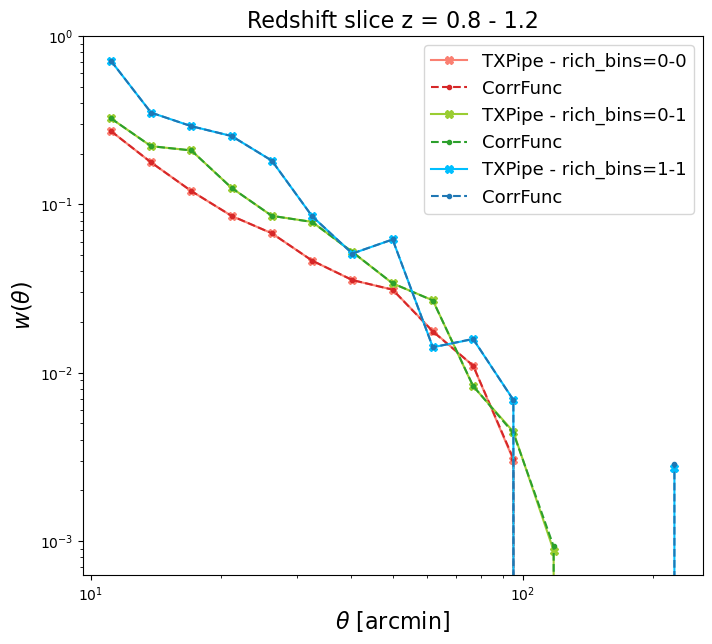

In [21]:
iz  = 1

cvec0 = ['salmon','yellowgreen','deepskyblue']
cvec1 = ['C3','C2','C0']

# read w(theta) from sacc file (saved before)   
s  = sacc.Sacc.load_fits("examples/twopoint_cluster/outputs/test/cluster_twopoint_real.sacc")

# mean separation bins
theta_m   = 10**(np.log10(theta[1:]*theta[:-1])/2)

plt.figure(figsize=(8,7))
for il in range(nbins_l):
    for jl in range(il,nbins_l):
        w_txpipe = s.get_mean('cluster_density_xi', ('zbin_%s_richbin_%s' %(iz,il), 'zbin_%s_richbin_%s' %(iz,jl)))
        
        plt.plot(theta_m, w_txpipe,  'X-', c=cvec0[il+jl], label='TXPipe - rich_bins=%s-%s' %(il,jl))
        plt.plot(theta_m, w_corrfunc['zbin_%s_rich_bin_%s - rich_bin_%s' %(iz,il,jl)],  '.--', c=cvec1[il+jl],  label='CorrFunc')
    
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=13,loc=0)
plt.xlabel(r'$\theta$ [arcmin]', fontsize=16)
plt.ylabel(r'$w(\theta)$', fontsize=16)
plt.title(r'Redshift slice z = %1.1f - %1.1f' %(zbins[iz],zbins[iz+1]), fontsize=16)
